In [92]:
# load modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle
from google.cloud import bigquery
#load libraries
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import xgboost
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn import svm

In [116]:
import pandas as pd

#Load the training data set

# Create a client object and authenticate
client = bigquery.Client.from_service_account_json('./service_account_key.json')

#Fetching train data from BigQuery
query_train = """
SELECT *
FROM `ecommerce-fraud-detection.Train.training`
"""

#Fetching test data from BigQuery

query_test = """
SELECT *
FROM `ecommerce-fraud-detection.Test.test`
"""

# Execute the query and return the results as a pandas dataframe
df_train = client.query(query_train).to_dataframe()

# Execute the query and return the results as a pandas dataframe
df_test = client.query(query_test).to_dataframe()

#View first 5 rows
df_train.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_110764,BatchId_121350,AccountId_388,SubscriptionId_2663,CustomerId_718,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,256.0,256,2018-11-24 06:14:44+00:00,2,0
1,TransactionId_34261,BatchId_126649,AccountId_1518,SubscriptionId_3931,CustomerId_1889,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,512.0,512,2018-12-28 08:49:37+00:00,2,0
2,TransactionId_14589,BatchId_109623,AccountId_2804,SubscriptionId_128,CustomerId_3225,UGX,256,ProviderId_6,ProductId_3,airtime,ChannelId_3,512.0,512,2019-01-24 16:45:16+00:00,2,0
3,TransactionId_68313,BatchId_67732,AccountId_3710,SubscriptionId_1340,CustomerId_4152,UGX,256,ProviderId_6,ProductId_14,financial_services,ChannelId_3,512.0,512,2018-11-30 05:21:34+00:00,2,0
4,TransactionId_24555,BatchId_87255,AccountId_4076,SubscriptionId_4102,CustomerId_4526,UGX,256,ProviderId_5,ProductId_15,financial_services,ChannelId_3,512.0,512,2019-01-06 17:16:42+00:00,2,0


In [94]:
#Summary of numerical attributes
df_train.describe()

,CountryCode,Amount,Value,PricingStrategy,FraudResult
count,95662.0,9.566200e+04,9.566200e+04,95662.000000,95662.000000
mean,256.0,6.717846e+03,9.900584e+03,2.255974,0.002018
std,0.0,1.233068e+05,1.231221e+05,0.732924,0.044872
min,256.0,-1.000000e+06,2.000000e+00,0.000000,0.000000
25%,256.0,-5.000000e+01,2.750000e+02,2.000000,0.000000
50%,256.0,1.000000e+03,1.000000e+03,2.000000,0.000000
75%,256.0,2.800000e+03,5.000000e+03,2.000000,0.000000
max,256.0,9.880000e+06,9.880000e+06,4.000000,1.000000


In [95]:
# checking the balance of the data
print('The number of Non-Frauds are: ' + str(df_train['FraudResult'].value_counts()[0]) + ' which is', round(df_train['FraudResult'].value_counts()[0]/len(df_train) * 100,2), '% of the dataset')
print('The number of Frauds are: ' + str(df_train['FraudResult'].value_counts()[1]) + ' which is', round(df_train['FraudResult'].value_counts()[1]/len(df_train) * 100,2), '% of the dataset')

The number of Non-Frauds are: 95469 which is 99.8 % of the dataset
The number of Frauds are: 193 which is 0.2 % of the dataset


<AxesSubplot:xlabel='FraudResult', ylabel='count'>

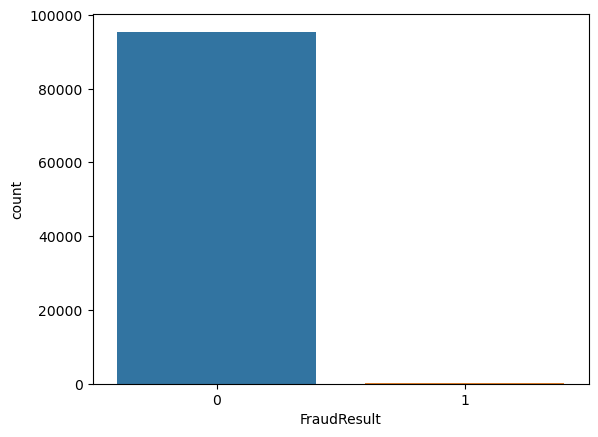

In [97]:
# visualize category class
sns.countplot(x='FraudResult', data=df_train)

<function matplotlib.pyplot.show(close=None, block=None)>

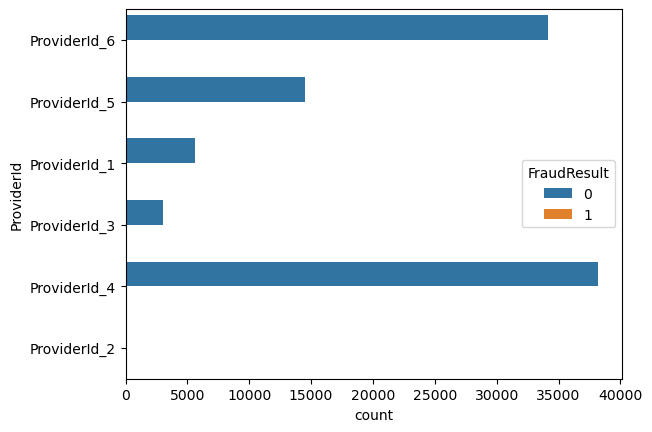

In [98]:
# pricing and fraudresults
sns.countplot(y='ProviderId', data=df_train, hue='FraudResult')
plt.show

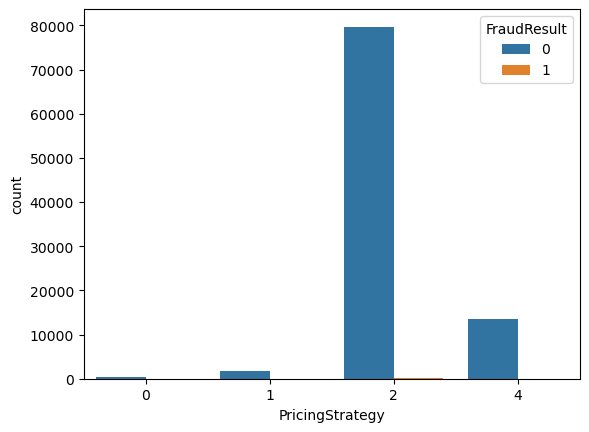

In [99]:
# pricingstrategy and fraudresult
sns.countplot(x='PricingStrategy', data=df_train, hue='FraudResult')
plt.show()

Data Cleaning

In [117]:
def splitTimeStamp(df):
 df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'], infer_datetime_format=True) 
 df['Year'] = df['TransactionStartTime'].dt.year
 df['Month'] = df['TransactionStartTime'].dt.month
 df['Day'] = df['TransactionStartTime'].dt.day
 df['Hour'] = df['TransactionStartTime'].dt.hour
 df['Minute'] = df['TransactionStartTime'].dt.minute
 df['Seconds'] = df['TransactionStartTime'].dt.second
 df['week'] = df['TransactionStartTime'].dt.week
 df['weekday'] = df['TransactionStartTime'].dt.weekday
 return df

def correctTimeStamp(df):
  df['TransactionStartTime'] = df['TransactionStartTime'].astype(str).str.replace('T', ' ')
  df['TransactionStartTime'] = df['TransactionStartTime'].astype(str).str.replace('Z', '')
  return splitTimeStamp(df)

def dataCleaner(df):
  # Check for missing values
  print(df.isnull().sum())

  # Drop rows with missing values
  df = df.dropna()
  
  # Check for duplicates
  print(df.duplicated().sum())

  # Drop duplicates
  df = df.drop_duplicates()

  return correctTimeStamp(df)

df_train = dataCleaner(df_train)
df_test = dataCleaner(df_test)

TransactionId           0
BatchId                 0
AccountId               0
SubscriptionId          0
CustomerId              0
CurrencyCode            0
CountryCode             0
ProviderId              0
ProductId               0
ProductCategory         0
ChannelId               0
Amount                  0
Value                   0
TransactionStartTime    0
PricingStrategy         0
FraudResult             0
dtype: int64
0


C:\Users\nidhi\AppData\Local\Temp\ipykernel_8064\2861019983.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week'] = df['TransactionStartTime'].dt.week


TransactionId           0
BatchId                 0
AccountId               0
SubscriptionId          0
CustomerId              0
CurrencyCode            0
CountryCode             0
ProviderId              0
ProductId               0
ProductCategory         0
ChannelId               0
Amount                  0
Value                   0
TransactionStartTime    0
PricingStrategy         0
dtype: int64
0


C:\Users\nidhi\AppData\Local\Temp\ipykernel_8064\2861019983.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week'] = df['TransactionStartTime'].dt.week


In [118]:
#Drop irrelevant attributes
df_train = df_train.drop(['TransactionId', 'CurrencyCode', 'CountryCode', 'TransactionStartTime'], axis=1)
df_train.head()

,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,PricingStrategy,FraudResult,Year,Month,Day,Hour,Minute,Seconds,week,weekday
0,BatchId_121350,AccountId_388,SubscriptionId_2663,CustomerId_718,ProviderId_6,ProductId_1,airtime,ChannelId_3,256.0,256,2,0,2018,11,24,6,14,44,47,5
1,BatchId_126649,AccountId_1518,SubscriptionId_3931,CustomerId_1889,ProviderId_6,ProductId_10,airtime,ChannelId_3,512.0,512,2,0,2018,12,28,8,49,37,52,4
2,BatchId_109623,AccountId_2804,SubscriptionId_128,CustomerId_3225,ProviderId_6,ProductId_3,airtime,ChannelId_3,512.0,512,2,0,2019,1,24,16,45,16,4,3
3,BatchId_67732,AccountId_3710,SubscriptionId_1340,CustomerId_4152,ProviderId_6,ProductId_14,financial_services,ChannelId_3,512.0,512,2,0,2018,11,30,5,21,34,48,4
4,BatchId_87255,AccountId_4076,SubscriptionId_4102,CustomerId_4526,ProviderId_5,ProductId_15,financial_services,ChannelId_3,512.0,512,2,0,2019,1,6,17,16,42,1,6


In [112]:
#imbalance in data
count_class_0, count_class_1 = df_train.FraudResult.value_counts()

# divide by class
train_class_0 = df_train[df_train['FraudResult'] == 0]
train_class_1 = df_train[df_train['FraudResult'] == 1]

print(train_class_0.shape)
print(train_class_1.shape)

(95469, 17)
(193, 17)


Imputation of numerical features

In [119]:
#import libraries
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


# Select columns with numerical features
num_columns = ['Amount', 'Value', 'PricingStrategy', 'Year',	'Month',	'Day',	'Hour',	'Minute',	'Seconds',	'week',	'weekday']
cat_columns = ['BatchId',	'SubscriptionId',	'CustomerId', 'ProviderId', 'ProductId',	'ProductCategory', 'ChannelId',]

imputation of categorical features

In [120]:
# Initialize the imputer with the most frequent strategy
num_pipeline = make_pipeline(SimpleImputer(strategy = "mean"), StandardScaler())
cat_pipeline = make_pipeline(SimpleImputer(strategy = "most_frequent"), OneHotEncoder(handle_unknown="ignore"))
preprocessing = ColumnTransformer([("num", num_pipeline, num_columns), ("cat", cat_pipeline, cat_columns)])


y = df_train.FraudResult
X = preprocessing.fit_transform(df_train.drop('FraudResult',axis=1))

In [88]:

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state=42)
X_test_bkp=X_test


In [15]:
#SMOTE 
from imblearn.combine import SMOTETomek
from collections import Counter
Counter(y_train)
smt = SMOTETomek(sampling_strategy=0.75)

# Resample the dataset using SMOTETomek
X_train_ns, y_train_ns = smt.fit_resample(X_train, y_train)

# Print the number of classes before and after fit
print("The number of classes before fit: {}".format(Counter(y_train)))
print("The number of classes after fit: {}".format(Counter(y_train_ns)))

The number of classes before fit: Counter({0: 76389, 1: 140})
The number of classes after fit: Counter({0: 76389, 1: 57291})


In [18]:
#with SMOTING
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report


#initializning base models
lr = LogisticRegression(random_state=42,max_iter=400)
dt = DecisionTreeClassifier(random_state=42)
gnb = GaussianNB()
rf_clasfr = RandomForestClassifier(random_state=42)
gradient_b_clsfr=GradientBoostingClassifier(random_state=42)
ada_b_clsfr=AdaBoostClassifier(random_state=42)

#creating a dict for all 7 models
model_list = {'Decision_Tree':dt,'Random Forest':rf_clasfr
             ,'Gradient_Boosting':gradient_b_clsfr,'Ada Boost':ada_b_clsfr,'Logistic Regression' :lr  }

# model_list = {'Logistic Regression' :lr  }  

#training each models one by one and predicting 
for model_name,model in model_list.items():
    model.fit(X_train_ns, y_train_ns)
    y_pred=model.predict(X_test)
    print(model_name)
    print("Model Score is: ",round(model.score(X_test, y_test),3))
    print("F1 Score is " ,round(f1_score(y_test, y_pred,),3))
    print("Accuracy Score is",accuracy_score(y_test,y_pred))
    print("Precision Score is ", precision_score(np.array(y_test), np.floor(y_pred)))
    print("Recall Score is ", recall_score(np.array(y_test), np.floor(y_pred)))
    print("\n")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("\n")
    

Decision_Tree
Model Score is:  0.999
F1 Score is  0.806
Accuracy Score is 0.9987456227460408
Precision Score is  0.704225352112676
Recall Score is  0.9433962264150944


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19080
           1       0.70      0.94      0.81        53

    accuracy                           1.00     19133
   macro avg       0.85      0.97      0.90     19133
weighted avg       1.00      1.00      1.00     19133



Random Forest
Model Score is:  0.999
F1 Score is  0.747
Accuracy Score is 0.9987978884649559
Precision Score is  0.8947368421052632
Recall Score is  0.6415094339622641


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19080
           1       0.89      0.64      0.75        53

    accuracy                           1.00     19133
   macro avg       0.95      0.82      0.87     19133
weighted avg  

Cross Validation of Best performing model

In [63]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
num_folds = 5
#Defining the cross-validation method
kfold = KFold(n_splits=num_folds)

# Perform cross-validation on the model
scores = cross_val_score(ada_b_clsfr, X, y, cv=kfold)

#Cross-validation scores
print("Cross-validation scores:", scores)

# calculate the mean and standard deviation of the cross-validation scores
mean_score = scores.mean()
std_score = scores.std()
print("Mean score:", mean_score)
print("Standard deviation:", std_score)

Cross-validation scores: [0.99958187 0.99858883 0.99932051 0.99984319 0.99989546]
Mean score: 0.999445973544848
Standard deviation: 0.00047512906632269383


Hyper parameter tuning using random forest to optimize the model

In [66]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import uniform, randint
import numpy as np


# Define the parameter distributions for hyperparameter tuning
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(2, 6),
    'learning_rate': uniform(0.01, 0.1),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5)
}

# Use RandomizedSearchCV to perform hyperparameter tuning with 5-fold cross-validation
grid = RandomizedSearchCV(gradient_b_clsfr, param_distributions=param_dist, n_iter=100, cv=5, scoring='neg_mean_squared_error', random_state=42)
grid.fit(X_train, y_train)

# Print the best hyperparameters and mean squared error on the testing set
print("Best hyperparameters:", grid.best_params_)
y_pred = grid.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean squared error on the testing set:", mse)

KeyboardInterrupt: 

In [19]:
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(ada_b_clsfr, open(filename, 'wb'))

In [60]:
tdf = pd.DataFrame(X_test)
tdf['real'] = np.array(y_test)
tdf['pred'] = np.array(result)
tdf

,0,real,pred
0,"(0, 0)\t-0.05042608417023344\n (0, 1)\t-0.0...",0,0
1,"(0, 0)\t-0.038261241074308935\n (0, 1)\t-0....",0,0
2,"(0, 0)\t-0.038261241074308935\n (0, 1)\t-0....",0,0
3,"(0, 0)\t-0.013931554882459929\n (0, 1)\t-0....",0,0
4,"(0, 0)\t-0.04637113647159194\n (0, 1)\t-0.0...",0,0
...,...,...,...
19128,"(0, 0)\t-0.038261241074308935\n (0, 1)\t-0....",0,0
19129,"(0, 0)\t-0.05488652663873909\n (0, 1)\t-0.0...",0,0
19130,"(0, 0)\t0.026617922103955086\n (0, 1)\t0.00...",0,0
19131,"(0, 0)\t-0.05488652663873909\n (0, 1)\t-0.0...",0,0


In [62]:
tdf[tdf.real==1]

,0,real,pred
1069,"(0, 0)\t7.244424825685828\n (0, 1)\t7.22944...",1,1
1409,"(0, 0)\t4.000466666772626\n (0, 1)\t3.98061...",1,1
1458,"(0, 0)\t4.000466666772626\n (0, 1)\t3.98061...",1,1
1631,"(0, 0)\t4.324862482663947\n (0, 1)\t4.30550...",1,1
1721,"(0, 0)\t4.000466666772626\n (0, 1)\t3.98061...",1,1
1747,"(0, 0)\t4.405961436636776\n (0, 1)\t4.38672...",1,1
1762,"(0, 0)\t0.7565085078594252\n (0, 1)\t0.7317...",1,1
2225,"(0, 0)\t56.71478674911214\n (0, 1)\t56.7740...",1,1
3104,"(0, 0)\t4.000466666772626\n (0, 1)\t3.98061...",1,1
3263,"(0, 0)\t5.622445746229227\n (0, 1)\t5.60503...",1,1


In [ ]:
#Transform the variables into binary (0,1) - ROC Curve
    Forecast1=pd.DataFrame(y_pred)
    Outcome1=pd.DataFrame(y_test)
    lb1 = preprocessing.LabelBinarizer()
    OutcomeB1 =lb1.fit_transform(Outcome1)
    ForecastB1 = lb1.fit_transform(Forecast1)
    
    #Setup the ROC Curve
    fpr, tpr, threshold = metrics.roc_curve(OutcomeB1, ForecastB1)
    roc_auc = metrics.auc(fpr, tpr)
    print('ROC Curve')
    #Plot the ROC Curve
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [59]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.predict(X_test)
print(result)

[0 0 0 ... 0 0 0]


Sending email if fraud is detected

In [123]:
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from email.mime.application import MIMEApplication

# assume the prediction result is stored in a variable called 'prediction'
prediction = 1

# if the prediction is 1, send an email to the client
if prediction == 1:
    try:
        # set up the connection to the SMTP server
        server = smtplib.SMTP('smtp-relay.sendinblue.com', 587)
        server.starttls()
        server.ehlo()

        # replace 'sender_email' and 'sender_password' with your own credentials
        sender_email = 'ecommercefrauddetection@gmail.com'
        sender_password = 'TFkApQjyfqvhJaMc'
        server.login(sender_email, sender_password)

        # set up the email message
        message = MIMEMultipart()
        message['Subject'] = 'Fraud Detection Alert!'
        message['From'] = sender_email
        message['To'] = ', '.join(['roshnirav1891@gmail.com', 'nidhish1313@gmail.com', 'uks2k20@gmail.com','sabickchaliyam@gmail.com'])

        body = """Dear Valued Client,

We are writing to inform you that our fraud detection model has detected a potential fraudulent activity related to your account. As a precautionary measure, we urge you to take necessary actions to safeguard your account.

We advise you to closely monitor all transactions on your account and report any unauthorized activity immediately. Additionally, please change your account password to ensure the security of your account.

We take the security of your account seriously, and we are committed to ensuring that your personal and financial information remains secure.

Thank you for your prompt attention to this matter.

Sincerely,
Group 8 fraud detection """

        message.attach(MIMEText(body, 'plain'))

        # send the email
        server.sendmail(sender_email, ['roshnirav1891@gmail.com', 'nidhish1313@gmail.com', 'uks2k20@gmail.com','sabickchaliyam@gmail.com'], message.as_string())

        # close the connection to the SMTP server
        server.quit()

        print('Email sent successfully!')
    except Exception as e:
        print(f'Error occurred while sending email: {e}')


Email sent successfully!
